In [51]:
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

### Load data

In [24]:
households = pd.read_csv('/home/data/sfbay_synth_pop/sfbay_households_2018_07_02.csv',
    dtype={'state': str, 'county': str, 'tract': str, 'block group': str},
    index_col='household_id')
households['block_group_id'] = households['state'].str.zfill(2) + households['county'].str.zfill(3) + \
    households['tract'].str.zfill(6) + households['block group']
households['unit_id'] = -1

/home/max/anaconda3/envs/urbansim/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
store = pd.HDFStore('/home/data/bayarea_ual.h5')

Opening /home/data/bayarea_ual.h5 in read-only mode


In [25]:
buildings = store['buildings']
parcels = store['parcels']
parcels['block_group_id'] = parcels['block_id'].str[0:12]

In [26]:
units = pd.read_csv('/home/data/units_w_tenure.csv', index_col='unit_id')

/home/max/anaconda3/envs/urbansim/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [27]:
units['vacant'] = 1

In [28]:
units_w_bldgs = pd.merge(units, buildings, left_on='building_id', right_index=True)

In [29]:
units_w_parcels = pd.merge(units_w_bldgs, parcels, left_on='parcel_id', right_index=True)

#### Make sure the merge hasn't dropped any units

In [ ]:
assert len(units_w_parcels) == len(units)

In [31]:
assert len(units_w_parcels[pd.isnull(units_w_parcels['block_group_id'])]) == 0

### Compare Block Level Counts

Points should fall on or near the line $x=y$

[]

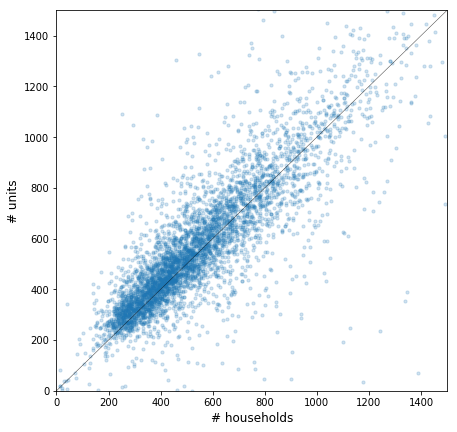

In [58]:
a = households[['serialno','block_group_id']].groupby('block_group_id').count()

b = units_w_parcels.reset_index()[['unit_id','block_group_id']].groupby('block_group_id').count()

merged = pd.merge(a,b, on='block_group_id')

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(merged['serialno'], merged['unit_id'], s=10, alpha=0.2)
ax.set_xlim(0,1500)
ax.set_ylim(0,1500)
lims = [0, 1500]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, lw=0.5)
ax.set_xlabel('# households', fontsize=12)
ax.set_ylabel('# units', fontsize=12)
ax.plot()

### Block-level allocation

For the SF Bay Area synthetic population this code achieves a rate of 7% unplaced househoulds and ~11% vacant units

In [ ]:
no_units = []
no_hhs = []

for bg_id in tqdm(parcels['block_group_id'].unique()):
    
    bg_units = units_w_parcels[units_w_parcels['block_group_id'] == bg_id]
    bg_unit_counts.append(len(bg_units))
    if len(bg_units) == 0:
        no_units.append(bg_id)
        bg_hh_counts.append(0)
        continue
        
    bg_hhs = households[households['block_group_id'] == bg_id]
    bg_hh_counts.append(len(bg_hhs))
    if len(bg_hhs) == 0:
        no_hhs.append(bg_id)
        continue
    
    units.loc[bg_units.iloc[0:len(bg_hhs)].index, 'vacant'] = 0
    households.loc[bg_hhs.iloc[0:len(bg_units)].index, 'unit_id'] = bg_units.index[0:len(bg_hhs)]

 48%|████▊     | 2298/4775 [50:39<54:36,  1.32s/it]  

In [43]:
print('{0}% of block groups contained no residential units'.format(
    round(len(no_units) / len(parcels['block_group_id'].unique()) * 100, 1)))

print('{0}% of block groups had no households'.format(
    round(len(no_hhs) / len(parcels['block_group_id'].unique()) * 100, 1)))

print('{0}% of households remain unplaced after allocation'.format(
    round(len(households[households['unit_id'] == -1]) / len(households) * 100, 1)))

print('{0}% of residential units remain vacant after allocation'.format(
    round(len(units[units['vacant'] == 1]) / len(units) * 100, 1)))

1.1% of block groups contained no residential units
0.1% of block groups had no households
7.1% of households remain unplaced after allocation
10.6% of residential units remain vacant after allocation
